In [1]:
%matplotlib notebook
#add comments
import os
import sys
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc, create_spec, load_wav
from glob import glob

from torch.utils.data import Dataset
from CustomAudioDataset import CustomAudioDataset

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd

from TweetyNetModel import TweetyNetModel  

In [2]:
train = True
fineTuning = False
#needs at least 80 for mel spectrograms ## may be able to do a little less, but must be greater than 60
n_mels=72 # The closest we can get tmeporally is 72 with an output of 432 : i think it depends on whats good
#this number should be proportional to the length of the videos. 
datasets_dir = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/Cosmos_data"
this_is_new_data = False

In [3]:
import pandas as pd
import numpy as np


#TODO Add mutliple species support for ROC curves 
def annotation_chunker_no_duplicates(kaleidoscope_df, chunk_length, include_no_bird=False, bird=None):
    """
    Function that converts a Kaleidoscope-formatted Dataframe containing 
    annotations to uniform chunks of chunk_length. If there
    are mutliple bird species in the same clip, this function creates chunks
    for the more confident bird species.

    Note: if all or part of an annotation covers the last < chunk_length
    seconds of a clip it will be ignored. If two annotations overlap in 
    the same 3 second chunk, both are represented in that chunk
    Args:
        kaleidoscope_df (Dataframe)
            - Dataframe of annotations in kaleidoscope format

        chunk_length (int)
            - duration to set all annotation chunks
    Returns:
        Dataframe of labels with chunk_length duration 
        (elements in "OFFSET" are divisible by chunk_length).
    """

    #Init list of clips to cycle through and output dataframe
    #kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"] 
    kaleidoscope_df['FILEPATH'] = kaleidoscope_df.loc[:,['FOLDER','IN FILE']].sum(axis=1)
    clips = kaleidoscope_df["FILEPATH"].unique()
    df_columns = {'FOLDER': 'str', 'IN FILE' :'str', 'CLIP LENGTH' : 'float64', 'CHANNEL' : 'int64', 'OFFSET' : 'float64',
                'DURATION' : 'float64', 'SAMPLE RATE' : 'int64','MANUAL ID' : 'str'}
    output_df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in df_columns.items()})
    
    # going through each clip
    for clip in clips:
        clip_df = kaleidoscope_df[kaleidoscope_df["FILEPATH"] == clip]
        path = clip_df["FOLDER"].unique()[0]
        file = clip_df["IN FILE"].unique()[0]
        birds = clip_df["MANUAL ID"].unique()
        sr = clip_df["SAMPLE RATE"].unique()[0]
        clip_len = clip_df["CLIP LENGTH"].unique()[0]

        # quick data sanitization to remove very short clips
        # do not consider any chunk that is less than chunk_length
        if clip_len < chunk_length:
            continue
        potential_annotation_count = int(clip_len)//int(chunk_length)

        # going through each species that was ID'ed in the clip
        arr_len = int(clip_len*1000)
        species_df = clip_df#[clip_df["MANUAL ID"] == bird]
        human_arr = np.zeros((arr_len))
        # looping through each annotation
        #print("========================================")
        for annotation in species_df.index:
            #print(species_df["OFFSET"][annotation])
            minval = int(round(species_df["OFFSET"][annotation] * 1000, 0))
            # Determining the end of a human label
            maxval = int(
                round(
                    (species_df["OFFSET"][annotation] +
                        species_df["DURATION"][annotation]) *
                    1000,
                    0))
            # Placing the label relative to the clip
            human_arr[minval:maxval] = 1
        # performing the chunk isolation technique on the human array

        for index in range(potential_annotation_count):
            #print("=======================")
            #print("-----------------------------------------")
            #print(index)
            chunk_start = index * (chunk_length*1000)
            chunk_end = min((index+1)*chunk_length*1000,arr_len)
            chunk = human_arr[int(chunk_start):int(chunk_end)]
            if max(chunk) >= 0.5:
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #Handle birdnet output edge case
                #print("-------------------------------------------")
                #print(sum(clip_df["DURATION"] == 3))
                #print(sum(clip_df["DURATION"] == 3)/clip_df.shape[0])
                #print("-------------------------------------------")
                if(sum(clip_df["DURATION"] == 3)/clip_df.shape[0] == 1):
                    #print("Processing here duration")
                    overlap = (clip_df["OFFSET"]+0.5 >= (annotation_start)) & (clip_df["OFFSET"]-0.5 <= (annotation_start))
                    annotation_df = clip_df[overlap]
                    #print(annotation_start, np.array(clip_df["OFFSET"]), overlap)
                    #print(annotation_df)
                else:
                    #print("Processing here")
                    overlap = is_overlap(clip_df["OFFSET"], clip_df["OFFSET"] + clip_df["DURATION"], annotation_start, annotation_start + chunk_length)
                    #print(overlap)
                    annotation_df = clip_df[overlap]
                    #print(annotation_df)
                
                #updating the dictionary
                if ('CONFIDENCE' in clip_df.columns):
                    annotation_df = annotation_df.sort_values(by="CONFIDENCE", ascending=False)
                    row["CONFIDENCE"] = annotation_df.iloc[0]["CONFIDENCE"]
                else:
                    #The case of manual id, or there is an annotation with no known confidence
                    row["CONFIDENCE"] = 1
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = annotation_df.iloc[0]["MANUAL ID"] 
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
            elif(include_no_bird):
                #print(max(chunk))
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #updating the dictionary
                row["CONFIDENCE"] = 0
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = "no bird"
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
    
    return output_df


def is_overlap(offset_df, end_df, chunk_start, chunk_end):
    is_both_before = (chunk_end < offset_df) & (chunk_start < offset_df)
    is_both_after = (end_df < chunk_end) & (end_df < chunk_start)
    return (~is_both_before) & (~is_both_after)
    
    
    interval = pd.Interval(left=offset_df, right=end_df)
    print(interval)


def split_save_files(dataframe_of_data):
    chunked_df = annotation_chunker_no_duplicates(dataframe_of_data, 3, include_no_bird=True)
    
    
    chunked_df.apply()
    

In [56]:
from pydub import AudioSegment
import os

data = pd.read_csv("C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing/automated_cosmos_tweety_to_file.csv")
chunked_df = annotation_chunker_no_duplicates(data, 3, include_no_bird=True)
chunked_df

FOLDER  \
0      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...                                         ...   
39720  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39721  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39722  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39723  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39724  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
0      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
1      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
2      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
3      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
4      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
...                                                  ...          ...   
39720  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39721  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39722  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39723  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39724  XC99284 - Slate-throated Whitestart - Myioboru...     3.369796   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE                 MANUAL ID  \
0            0     0.0       3.0        44100  Microcerculus marginatus   
1            0     3.0       3.0        44100  Microcerculus marginatus   
2            0     6.0       3.0        44100  Microcerculus marginatus   
3            0     9.0       3.0        44100  Microcerculus marginatus   
4            0    12.0       3.0        44100  Microcerculus marginatus   
...        ...     ...       ...          ...                       ...   
39720        0     0.0       3.0        44100        Thraupis episcopus   
39721        0     3.0       3.0        44100        Thraupis episcopus   
39722        0     6.0       3.0        44100        Thraupis episcopus   
39723        0     9.0       3.0        44100                   no bird   
39724        0     0.0       3.0        44100        Myioborus miniatus   

       CONFIDENCE  
0        0.543653  
1        0.230806  
2        0.544028  
3        0.793030  
4        0.299593  
...           ...  
39720    0.943661  
39721    0.775321  
39722    0.775321  
39723    0.000000  
39724    1.000000  

[39725 rows x 9 columns]

In [57]:
chunked_df.iloc[0]["IN FILE"]

'XC100027 - Southern Nightingale-Wren - Microcerculus marginatus.mp3'

In [58]:
import pydub
pydub.AudioSegment.ffmpeg = "C:/Users/Siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"

In [59]:
from pydub import AudioSegment
AudioSegment.converter = "C:/Users/Siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"
import os

path_to_audio = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing"
data_path = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
new_folder = data_path

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_to_audio) if isfile(join(path_to_audio, f))]
chunked_df = chunked_df[chunked_df["IN FILE"].isin(onlyfiles)]


chunked_renamed_df = chunked_df.copy()
count = 0
for filename in np.unique(chunked_df["IN FILE"]):
    file_df = chunked_df[chunked_df["IN FILE"] == filename]
    if (len(filename.split(".")) != 2):
        break
    file, file_type = filename.split(".")
    for index,row in file_df.iterrows():
        t1 = row["OFFSET"] * 1000
        # end time in milliseconds
        t2 = (row["OFFSET"] + 3) * 1000
        new_name = file + "_" + str(int(row["OFFSET"])) +"." + file_type
        new_path = new_folder + "/" + new_name
        
        if(this_is_new_data):
            newAudio = AudioSegment.from_mp3(path_to_audio + "/" + filename)
            newAudio = newAudio[t1:t2]
            newAudio.export(new_path, format="mp3")

        chunked_renamed_df.at[index, "IN FILE"] = new_name
        chunked_renamed_df.at[index, "FOLDER"] = new_folder
        count += 1
        print(count, "out of 6451")

        
chunked_renamed_df = chunked_renamed_df[chunked_renamed_df["IN FILE"] != "TO DELETE"]
chunked_renamed_df
    
    

1 out of 6451
2 out of 6451
3 out of 6451
4 out of 6451
5 out of 6451
6 out of 6451
7 out of 6451
8 out of 6451
9 out of 6451
10 out of 6451
11 out of 6451
12 out of 6451
13 out of 6451
14 out of 6451
15 out of 6451
16 out of 6451
17 out of 6451
18 out of 6451
19 out of 6451
20 out of 6451
21 out of 6451
22 out of 6451
23 out of 6451
24 out of 6451
25 out of 6451
26 out of 6451
27 out of 6451
28 out of 6451
29 out of 6451
30 out of 6451
31 out of 6451
32 out of 6451
33 out of 6451
34 out of 6451
35 out of 6451
36 out of 6451
37 out of 6451
38 out of 6451
39 out of 6451
40 out of 6451
41 out of 6451
42 out of 6451
43 out of 6451
44 out of 6451
45 out of 6451
46 out of 6451
47 out of 6451
48 out of 6451
49 out of 6451
50 out of 6451
51 out of 6451
52 out of 6451
53 out of 6451
54 out of 6451
55 out of 6451
56 out of 6451
57 out of 6451
58 out of 6451
59 out of 6451
60 out of 6451
61 out of 6451
62 out of 6451
63 out of 6451
64 out of 6451
65 out of 6451
66 out of 6451
67 out of 6451
68 o

844 out of 6451
845 out of 6451
846 out of 6451
847 out of 6451
848 out of 6451
849 out of 6451
850 out of 6451
851 out of 6451
852 out of 6451
853 out of 6451
854 out of 6451
855 out of 6451
856 out of 6451
857 out of 6451
858 out of 6451
859 out of 6451
860 out of 6451
861 out of 6451
862 out of 6451
863 out of 6451
864 out of 6451
865 out of 6451
866 out of 6451
867 out of 6451
868 out of 6451
869 out of 6451
870 out of 6451
871 out of 6451
872 out of 6451
873 out of 6451
874 out of 6451
875 out of 6451
876 out of 6451
877 out of 6451
878 out of 6451
879 out of 6451
880 out of 6451
881 out of 6451
882 out of 6451
883 out of 6451
884 out of 6451
885 out of 6451
886 out of 6451
887 out of 6451
888 out of 6451
889 out of 6451
890 out of 6451
891 out of 6451
892 out of 6451
893 out of 6451
894 out of 6451
895 out of 6451
896 out of 6451
897 out of 6451
898 out of 6451
899 out of 6451
900 out of 6451
901 out of 6451
902 out of 6451
903 out of 6451
904 out of 6451
905 out of 6451
906 out 

1648 out of 6451
1649 out of 6451
1650 out of 6451
1651 out of 6451
1652 out of 6451
1653 out of 6451
1654 out of 6451
1655 out of 6451
1656 out of 6451
1657 out of 6451
1658 out of 6451
1659 out of 6451
1660 out of 6451
1661 out of 6451
1662 out of 6451
1663 out of 6451
1664 out of 6451
1665 out of 6451
1666 out of 6451
1667 out of 6451
1668 out of 6451
1669 out of 6451
1670 out of 6451
1671 out of 6451
1672 out of 6451
1673 out of 6451
1674 out of 6451
1675 out of 6451
1676 out of 6451
1677 out of 6451
1678 out of 6451
1679 out of 6451
1680 out of 6451
1681 out of 6451
1682 out of 6451
1683 out of 6451
1684 out of 6451
1685 out of 6451
1686 out of 6451
1687 out of 6451
1688 out of 6451
1689 out of 6451
1690 out of 6451
1691 out of 6451
1692 out of 6451
1693 out of 6451
1694 out of 6451
1695 out of 6451
1696 out of 6451
1697 out of 6451
1698 out of 6451
1699 out of 6451
1700 out of 6451
1701 out of 6451
1702 out of 6451
1703 out of 6451
1704 out of 6451
1705 out of 6451
1706 out of 64

2556 out of 6451
2557 out of 6451
2558 out of 6451
2559 out of 6451
2560 out of 6451
2561 out of 6451
2562 out of 6451
2563 out of 6451
2564 out of 6451
2565 out of 6451
2566 out of 6451
2567 out of 6451
2568 out of 6451
2569 out of 6451
2570 out of 6451
2571 out of 6451
2572 out of 6451
2573 out of 6451
2574 out of 6451
2575 out of 6451
2576 out of 6451
2577 out of 6451
2578 out of 6451
2579 out of 6451
2580 out of 6451
2581 out of 6451
2582 out of 6451
2583 out of 6451
2584 out of 6451
2585 out of 6451
2586 out of 6451
2587 out of 6451
2588 out of 6451
2589 out of 6451
2590 out of 6451
2591 out of 6451
2592 out of 6451
2593 out of 6451
2594 out of 6451
2595 out of 6451
2596 out of 6451
2597 out of 6451
2598 out of 6451
2599 out of 6451
2600 out of 6451
2601 out of 6451
2602 out of 6451
2603 out of 6451
2604 out of 6451
2605 out of 6451
2606 out of 6451
2607 out of 6451
2608 out of 6451
2609 out of 6451
2610 out of 6451
2611 out of 6451
2612 out of 6451
2613 out of 6451
2614 out of 64

3309 out of 6451
3310 out of 6451
3311 out of 6451
3312 out of 6451
3313 out of 6451
3314 out of 6451
3315 out of 6451
3316 out of 6451
3317 out of 6451
3318 out of 6451
3319 out of 6451
3320 out of 6451
3321 out of 6451
3322 out of 6451
3323 out of 6451
3324 out of 6451
3325 out of 6451
3326 out of 6451
3327 out of 6451
3328 out of 6451
3329 out of 6451
3330 out of 6451
3331 out of 6451
3332 out of 6451
3333 out of 6451
3334 out of 6451
3335 out of 6451
3336 out of 6451
3337 out of 6451
3338 out of 6451
3339 out of 6451
3340 out of 6451
3341 out of 6451
3342 out of 6451
3343 out of 6451
3344 out of 6451
3345 out of 6451
3346 out of 6451
3347 out of 6451
3348 out of 6451
3349 out of 6451
3350 out of 6451
3351 out of 6451
3352 out of 6451
3353 out of 6451
3354 out of 6451
3355 out of 6451
3356 out of 6451
3357 out of 6451
3358 out of 6451
3359 out of 6451
3360 out of 6451
3361 out of 6451
3362 out of 6451
3363 out of 6451
3364 out of 6451
3365 out of 6451
3366 out of 6451
3367 out of 64

4128 out of 6451
4129 out of 6451
4130 out of 6451
4131 out of 6451
4132 out of 6451
4133 out of 6451
4134 out of 6451
4135 out of 6451
4136 out of 6451
4137 out of 6451
4138 out of 6451
4139 out of 6451
4140 out of 6451
4141 out of 6451
4142 out of 6451
4143 out of 6451
4144 out of 6451
4145 out of 6451
4146 out of 6451
4147 out of 6451
4148 out of 6451
4149 out of 6451
4150 out of 6451
4151 out of 6451
4152 out of 6451
4153 out of 6451
4154 out of 6451
4155 out of 6451
4156 out of 6451
4157 out of 6451
4158 out of 6451
4159 out of 6451
4160 out of 6451
4161 out of 6451
4162 out of 6451
4163 out of 6451
4164 out of 6451
4165 out of 6451
4166 out of 6451
4167 out of 6451
4168 out of 6451
4169 out of 6451
4170 out of 6451
4171 out of 6451
4172 out of 6451
4173 out of 6451
4174 out of 6451
4175 out of 6451
4176 out of 6451
4177 out of 6451
4178 out of 6451
4179 out of 6451
4180 out of 6451
4181 out of 6451
4182 out of 6451
4183 out of 6451
4184 out of 6451
4185 out of 6451
4186 out of 64

5011 out of 6451
5012 out of 6451
5013 out of 6451
5014 out of 6451
5015 out of 6451
5016 out of 6451
5017 out of 6451
5018 out of 6451
5019 out of 6451
5020 out of 6451
5021 out of 6451


FOLDER  \
201    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
202    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
203    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
268    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
269    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
...                                                  ...   
39653           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39654           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39655           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39656           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39657           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
201    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
202    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
203    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
268    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
269    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
39653  XC97532 - Blue-grey Tanager - Thraupis episcop...    20.297143   
39654  XC97542 - Slate-throated Whitestart - Myioboru...     4.362449   
39655  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39656  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39657  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
201          0     0.0       3.0        44100  Zonotrichia capensis   
202          0     3.0       3.0        44100  Zonotrichia capensis   
203          0     6.0       3.0        44100  Zonotrichia capensis   
268          0     0.0       3.0        44100     Turdus leucomelas   
269          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
39653        0    15.0       3.0        44100    Thraupis episcopus   
39654        0     0.0       3.0        44100    Myioborus miniatus   
39655        0     0.0       3.0        44100  Zonotrichia capensis   
39656        0     3.0       3.0        44100  Zonotrichia capensis   
39657        0     6.0       3.0        44100  Zonotrichia capensis   

       CONFIDENCE  
201      0.914495  
202      0.157588  
203      1.000000  
268      0.743005  
269      0.842912  
...           ...  
39653    0.282231  
39654    0.977568  
39655    0.583067  
39656    0.648309  
39657    0.668926  

[6451 rows x 9 columns]

In [60]:
x = chunked_renamed_df.groupby(["IN FILE", "OFFSET"]).count().sort_values(by="MANUAL ID", ascending=False)
x.shape[0]

6451

In [61]:
def show_mel_spectrogram(spec, uid):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title=uid)
    plt.show()

In [62]:
def load_dataset(data_path, use_dump=True, csv="labels.csv", kalediscope=False):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    
    elif kalediscope:
        dataset = compute_feature_kaledoscope_labels(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    else:
        dataset = compute_feature(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path, csv = "labels.csv"):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, csv)
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, _, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def compute_feature_df(data_path, df):
    
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

In [63]:
species = list(np.unique(chunked_renamed_df["MANUAL ID"]))
chunked_renamed_df["y"] = chunked_renamed_df["MANUAL ID"].apply(lambda x: species.index(x))
chunked_renamed_df

FOLDER  \
201    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
202    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
203    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
268    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
269    C:/Users/Siloux/Desktop/E4E/passive-acoustic-b...   
...                                                  ...   
39653           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39654           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39655           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39656           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39657           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
201    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
202    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
203    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
268    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
269    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
39653  XC97532 - Blue-grey Tanager - Thraupis episcop...    20.297143   
39654  XC97542 - Slate-throated Whitestart - Myioboru...     4.362449   
39655  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39656  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39657  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
201          0     0.0       3.0        44100  Zonotrichia capensis   
202          0     3.0       3.0        44100  Zonotrichia capensis   
203          0     6.0       3.0        44100  Zonotrichia capensis   
268          0     0.0       3.0        44100     Turdus leucomelas   
269          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
39653        0    15.0       3.0        44100    Thraupis episcopus   
39654        0     0.0       3.0        44100    Myioborus miniatus   
39655        0     0.0       3.0        44100  Zonotrichia capensis   
39656        0     3.0       3.0        44100  Zonotrichia capensis   
39657        0     6.0       3.0        44100  Zonotrichia capensis   

       CONFIDENCE  y  
201      0.914495  9  
202      0.157588  9  
203      1.000000  9  
268      0.743005  7  
269      0.842912  7  
...           ... ..  
39653    0.282231  4  
39654    0.977568  2  
39655    0.583067  9  
39656    0.648309  9  
39657    0.668926  9  

[6451 rows x 10 columns]

In [64]:
import os
from pydub import AudioSegment

# You dont need the number of files in the folder, just iterate over them directly using:
if (this_is_new_data):
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        #spliting the file into the name and the extension
        name, ext = os.path.splitext(folder + '/' + file)
        if ext == ".mp3":
            #os.remove(folder + '/' + file) 

            mp3_sound = AudioSegment.from_mp3(folder + '/' + file)
            mp3_sound.export("{0}.wav".format(name), format="wav")

In [65]:
import os
from pydub import AudioSegment

if(this_is_new_data):
    # You dont need the number of files in the folder, just iterate over them directly using:
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        #spliting the file into the name and the extension
        name, ext = os.path.splitext(file)
        if ext == ".mp3":
            print(folder)
            try:
                os.remove(folder + "/" + file) 
            except Exception as e:
                print(e)
            

In [66]:
chunked_renamed_df["IN FILE"][201]

'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.mp3'

In [67]:
chunked_renamed_df["FOLDER"] = ".\cosmos_data\Cosmos_data"

In [68]:
chunked_renamed_df["IN FILE"] = chunked_renamed_df["IN FILE"].apply(lambda x: x.replace(".mp3", ".wav"))
chunked_renamed_df["IN FILE"][201]

'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav'

In [69]:
import os
from pydub import AudioSegment

# You dont need the number of files in the folder, just iterate over them directly using:
if(this_is_new_data):
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        sound = AudioSegment.from_wav(folder + "/" + file)
        sound = sound.set_channels(1)
        sound.export(folder + "/" + file, format="wav")


In [70]:
data_path = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
#chunked_renamed_df = pd.read_csv("formated_tweetynet_ground_truth.csv")
i = 1
X = []
Y = []
uids = []
for index, row in chunked_renamed_df.iterrows():
    try:
        print(f"{i:04d}/{chunked_renamed_df.shape[0]}", end="\r")
        print(os.path.join(data_path, row["IN FILE"]))
        spc = wav2spc(data_path + '/' + row["IN FILE"], n_mels=n_mels)
        X.append(spc)
        Y.append(row["y"])
        uids.append(row["IN FILE"])
        i += 1
    except Exception as e:
        print(e)
        continue
dataset = {"uids": uids, "X": X, "Y": Y}

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/Tw

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_45.wav
C:/Users/Siloux

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyN

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyN

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117394 - White-throated Toucan - Ramphastos tucanus cuvieri_51.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117394 - White-throated Toucan - Ramphastos tucanus cuvieri_54.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117394 - White-throated Toucan - Ramphastos tucanus cuvieri_57.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117394 - White-throated Toucan - Ramphastos tucanus cuvieri_60.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117394 - White-throated Toucan - Ramphastos tucanus cuvieri_63.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyN

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC119227 - Pale-breasted Thrush - Turdus leucomelas_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC119227 - Pale-breasted Thrush - Turdus leucomelas_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC119617 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC119617 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC119617 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_r

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12427 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127279 - Scaly-breasted Woodpecker - Celeus grammicus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_spli

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_66.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_69.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_72.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC129898 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC129898 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_6.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_78.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130873 - Pale-breasted Thrush - Turdus leucomelas_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130873 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130873 - Pale-breasted Thrush - Turdus leucomelas_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130873 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/Siloux/Desktop/E4E/passive-aco

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNE

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_51.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_51.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148387 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148387 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148392 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148392 - Scaly-breasted Woodpecker - Celeus grammicus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148392 - Scaly-breasted Woodpecker - Celeus grammicus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_samp

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_81.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_84.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_87.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_90.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_93.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148408 - Scaly-breasted Woodpecker - Celeus grammicus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148408 - Scaly-breasted Woodpecker - Celeus grammicus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148408 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148408 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148408 - Scaly-breasted Woodpecker - Celeus grammicus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC152846 - Blue-grey Tanager - Thraupis episcopus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/Users/Siloux/Desktop/

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC156278 - Blue-grey Tanager - Thraupis episcopus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC16207 - White-throated Toucan - Ramphastos tucanus tucanus_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC162072 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC162072 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC162072 - Slate-throated Whitestart - Myioborus miniatus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163745 - Blue-grey Tanager - Thraupis episcopus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC180765 - Blue-grey Tanager - Thraupis episcopus quaesita_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC180765 - Blue-grey Tanager - Thraupis episcopus quaesita_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC180765 - Blue-grey Tanager - Thraupis episcopus quaesita_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC180765 - Blue-grey Tanager - Thraupis episcopus quaesita_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC180765 - Blue-grey Tanager - Thraupis episcopus quaesita_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosm

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC188006 - Pale-breasted Thrush - Turdus leucomelas_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC188006 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC188006 - Pale-breasted Thrush - Turdus leucomelas_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC188006 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biod

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC195820 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC195820 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC195820 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC195820 - Rufous-collared Sparrow - Zonotrichia capensis_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_rando

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_75.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_78.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_81.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_84.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_87.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC20284

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_120.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_123.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_126.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_63.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_51.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_54.wav
C:/Users/Siloux/Desktop/E4E/pa

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226037 - Slate-throated Whitestart - Myioborus miniatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226037 - Slate-throated Whitestart - Myioborus miniatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226037 - Slate-throated Whitestart - Myioborus miniatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226037 - Slate-throated Whitestart - Myioborus miniatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226037 - Slate-throated Whitestart - Myioborus miniatus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_51.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_12.wav
C:/Users/

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acou

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_156.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_159.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_162.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_165.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_168.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/Tw

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_9.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_12.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_12.wav
C:/Users/Siloux/D

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247104 - White-throated Toucan - Ramphastos tucanus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247104 - White-throated Toucan - Ramphastos tucanus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247104 - White-throated Toucan - Ramphastos tucanus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247104 - White-throated Toucan - Ramphastos tucanus_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247104 - White-throated Toucan - Ramphastos tucanus_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_proc

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC250157 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC250157 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC250157 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_3.wav
C:/Us

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_171.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_174.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_177.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_180.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_183

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251780 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258045 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258046 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258046 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258046 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258046 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259682 - Blue-grey Tanager - Thraupis episcopus coelestis_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259682 - Blue-grey Tanager - Thraupis episcopus coelestis_36.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259682 - Blue-grey Tanager - Thraupis episcopus coelestis_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259682 - Blue-grey Tanager - Thraupis episcopus coelestis_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259682 - Blue-grey Tanager - Thraupis episcopus coelestis_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC263206 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC263206 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC263206 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC263206 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC263206 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_12.wav
C:/Users/

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC268594 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC268594 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC268594 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC268594 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC268594 - Yellow-olive Flatbil

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC271954 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC271954 - Pale-breasted Thrush - Turdus leucomelas_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC271954 - Pale-breasted Thrush - Turdus leucomelas_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC271954 - Pale-breasted Thrush - Turdus leucomelas_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC271954 - Pale-breasted Thrush - Turdus leucomelas_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_15.wav
C:/Users

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cos

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_120.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC293253 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC293253 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC293253 - Slate-throated Whitestart - Myioborus miniatus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC293253 - Slate-throated Whitestart - Myioborus miniatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC298029 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_39.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC298029 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_42.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC298029 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_45.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC298029 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_48.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC298029 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_51.wav
C:/Users/Siloux/Desktop/E4E/pa

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_21.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_24.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC301348 - White-throat

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC309193 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC309193 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC309193 - Southern Nightingale-Wren - Microcerculus marginatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC309193 - Southern Nightingale-Wren - Microcerculus marginatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC309193 - Southern Nightingale-Wren - Microcerculus marginatus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversit

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335120 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
C:/Users

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_72.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_75.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_78.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_81.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_84.wav
C:/Users/Siloux

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC356896 - Green-backed Trogon - Trogon viridis_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC356896 - Green-backed Trogon - Trogon viridis_33.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC356896 - Green-backed Trogon - Trogon viridis_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC356896 - Green-backed Trogon - Trogon viridis_36.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC356896 - Green-backed Trogon - Trogon viridis_36.wav
C:/Users/Siloux/Desktop/

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC38700 - Southern Nightingale-Wren - Microcerculus marginatus_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC38700 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC38700 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC38700 - Southern Nightingale-Wren - Microcerculus marginatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC38700 - Southern Nightingale-Wren - Microcerculus marginatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/Twee

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_30.wav
C:/Users/S

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_30.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_33.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC425688 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC425688 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC425688 - Rufous-collared Sparrow - Zonotrichia capensis_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428099 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/c

wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
wav file with wrong frequency 48000: C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - 

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436972 - White-throated Toucan - Ramphastos tucanus cuvieri_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436972 - White-throated Toucan - Ramphastos tucanus cuvieri_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436972 - White-throated Toucan - Ramphastos tucanus cuvieri_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436972 - White-throated Toucan - Ramphastos tucanus cuvieri_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436972 - White-throated Toucan - Ramphastos tucanus cuvieri_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversi

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_81.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_84.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_87.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_90.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_93.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-ba

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46139 - Pale-breasted Thrush - Turdus leucomelas_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46139 - Pale-breasted Thrush - Turdus leucomelas_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46139 - Pale-breasted Thrush - Turdus leucomelas_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46139 - Pale-breasted Thrush - Turdus leucomelas_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46150 - Buff-throated Woodcreeper - Xiphorhynchus guttatus polystictus_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sampl

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Blue-grey Tanager - Thraupis episcopus_15.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Blue-grey Tanager - Thraupis episcopus_24.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC47508 - Bl

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493912 - Slate-throated Whitestart - Myioborus miniatus ballux_9.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493912 - Slate-throated Whitestart - Myioborus miniatus ballux_12.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC494137 - Green-backed Trogon - Trogon viridis_0.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC494137 - Green-backed Trogon - Trogon viridis_3.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC494137 - Green-backed Trogon - Trogon viridis_6.wav
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_proc

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525440 - Green-backed Trogon - Trogon viridis_108.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC525440 - Green-backed Trogon - Trogon viridis_108.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525440 - Green-backed Trogon - Trogon viridis_111.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC525440 - Green-backed Trogon - Trogon viridis_111.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525440 - Green-backed Trogon - Trogon viridis_114.wav
[Errno 2] No such file or directory: 'C:/Users/Silou

[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotr

[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC63638 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC63638 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC63638 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC63638 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC63638 - Southern Nightin

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC69690 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC69690 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC69690 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC69690 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC69690 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-aco

C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC73831 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC73831 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC73831 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC73831 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC73831 - Southern Nightingale-Wren - Microcerculus marginatus.w

[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC91002 - Rufous-collared Sparrow - Zonotrichia capensis.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC91002 - Rufous-collared Sparrow - Zonotrichia capensis.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC91002 - Rufous-collared Sparrow - Zonotrichia capensis.wav'
C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC91002 - Rufous-collared Sparrow - Zonotrichia capensis.wav
[Errno 2] No such file or directory: 'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC91002 - Rufous-collared Sparrow - Zonotrichia ca

In [71]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_9.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_12.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_15.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_18.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_21.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_24.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_27.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_30.wav',
  'XC101469 - Pale-breasted Thrush - Turdus

In [72]:


inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 130]
X = np.array([dataset["X"][i].transpose() for i in inds])
Y = np.array([int(dataset["Y"][i]) for i in inds])
uids = [dataset["uids"][i] for i in inds]
X, Y, uids


(array([[[24.874008, 26.37475 , 24.874008, ..., 24.874008, 24.874008,
          24.874008],
         [63.904823, 61.36703 , 62.28552 , ..., 24.874008, 24.874008,
          24.874008],
         [70.09499 , 71.15409 , 72.341385, ..., 24.874008, 24.874008,
          24.874008],
         ...,
         [69.60951 , 68.95202 , 66.616356, ..., 24.874008, 24.874008,
          24.874008],
         [69.00752 , 68.65988 , 71.341705, ..., 24.874008, 24.874008,
          24.874008],
         [63.309593, 69.6176  , 69.48613 , ..., 24.874008, 24.874008,
          24.874008]],
 
        [[55.952545, 59.178352, 65.13502 , ..., 19.280636, 18.998732,
          18.515867],
         [62.761135, 69.90245 , 70.82655 , ..., 10.783119, 10.783119,
          10.783119],
         [68.85659 , 64.67638 , 66.7065  , ..., 10.783119, 10.783119,
          10.783119],
         ...,
         [69.900375, 67.10619 , 70.212036, ..., 10.783119, 10.783119,
          10.783119],
         [64.21452 , 67.490616, 65.32551 , ..., 1

In [73]:
dataset["X"][0].shape[1]


130

In [74]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_9.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_12.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_15.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_18.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_21.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_24.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_27.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_30.wav',
  'XC101469 - Pale-breasted Thrush - Turdus

In [75]:
#X0, Y0, uids0 = load_dataset(datasets_dir, csv="automated_cosmos_tweety_to_file.csv")#os.path.join(datasets_dir, "ff1010bird_wav"))
#print(X0)
#uids0, X0, Y0 =  uids, X,Y#load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))

#print(X0.shape)
#print(Y0.shape)
#print(len(uids0))

#X = np.concatenate([X0]).astype(np.float32)/255
#Y = np.concatenate([Y0])
#uids = np.concatenate([uids0])
#print(X.shape, Y.shape, uids.shape)
#del X0, Y0, uids0, X1, Y1, uids1 

In [76]:
Counter(Y)

Counter({9: 187,
         7: 254,
         10: 571,
         2: 267,
         1: 182,
         4: 310,
         8: 242,
         3: 367,
         0: 317,
         5: 242,
         6: 137})

Actual work

In [77]:
print(type(uids))
uids = np.array(uids)

<class 'list'>


In [78]:
ind_train_val, ind_test = split_dataset(X, Y)
ind_train, ind_val = split_dataset(X[ind_train_val, :, :, np.newaxis], Y[ind_train_val], test_size=0.1)
X_train, X_test, X_val = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis], X[ind_val, :, :, np.newaxis]
Y_train, Y_test, Y_val = Y[ind_train], Y[ind_test], Y[ind_val]
uids_train, uids_test, uids_val = uids[ind_train], uids[ind_test], uids[ind_val]
#del X, Y

print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({10: 410, 3: 299, 0: 273, 4: 237, 2: 217, 7: 189, 5: 166, 1: 125, 8: 117, 9: 94, 6: 87})
Test set:  Counter({10: 114, 3: 74, 0: 64, 4: 62, 2: 54, 7: 51, 5: 49, 8: 48, 9: 37, 1: 36, 6: 27})
Validation set:  Counter({10: 44, 4: 35, 0: 31, 3: 29, 2: 21, 7: 19, 5: 18, 1: 16, 6: 13, 9: 12, 8: 8})


In [79]:
len(Counter(Y_train))
X_train[0].shape

(130, 72, 1)

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
tweetynet = TweetyNetModel(len(Counter(Y_train)), (1, n_mels, 431), device, binary=True)

Using cpu device


In [81]:
train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)
val_dataset = CustomAudioDataset(X_val, Y_val, uids_val)

In [82]:
#train_dataset = train_dataset.type(torch.LongTensor)
#test_dataset = test_dataset.type(torch.LongTensor)
#val_dataset = val_dataset.type(torch.LongTensor)

In [83]:
train_dataset[:10]

(array([[[[63.708145 ],
          [71.075836 ],
          [69.486465 ],
          ...,
          [16.51562  ],
          [15.081106 ],
          [13.447218 ]],
 
         [[60.53101  ],
          [71.67428  ],
          [79.35291  ],
          ...,
          [ 5.758881 ],
          [ 6.1105175],
          [ 5.686941 ]],
 
         [[64.20473  ],
          [71.37669  ],
          [78.280655 ],
          ...,
          [ 5.7314844],
          [ 5.6580667],
          [ 6.064899 ]],
 
         ...,
 
         [[55.16588  ],
          [65.90971  ],
          [72.4301   ],
          ...,
          [ 4.865908 ],
          [ 5.9146905],
          [ 4.9520125]],
 
         [[64.90468  ],
          [68.32108  ],
          [72.42682  ],
          ...,
          [ 6.369191 ],
          [ 5.4596586],
          [ 5.199833 ]],
 
         [[67.57958  ],
          [73.741714 ],
          [78.05179  ],
          ...,
          [21.79676  ],
          [20.352919 ],
          [19.269917 ]]],
 
 
        [

In [84]:
%load_ext autoreload
%autoreload 2

Start of epoch: 0
[1,    10] loss: 23.307
Start of epoch: 1
[2,    10] loss: 22.559
Start of epoch: 2
[3,    10] loss: 21.662
Start of epoch: 3
[4,    10] loss: 21.658
Start of epoch: 4
[5,    10] loss: 21.417
Start of epoch: 5
[6,    10] loss: 21.331
Start of epoch: 6
[7,    10] loss: 21.334
Start of epoch: 7
[8,    10] loss: 21.074
Start of epoch: 8
[9,    10] loss: 20.910
Start of epoch: 9
[10,    10] loss: 20.823
Finished Training
Finished Testing


<IPython.core.display.Javascript object>


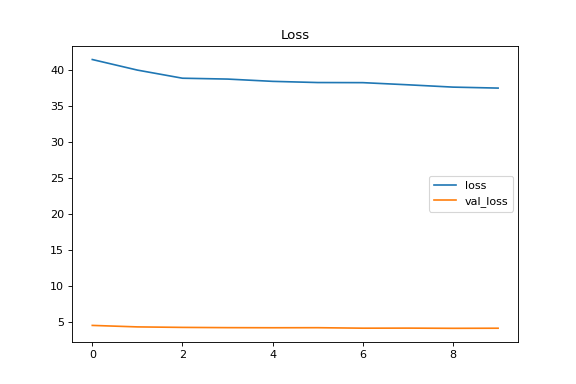

<IPython.core.display.Javascript object>


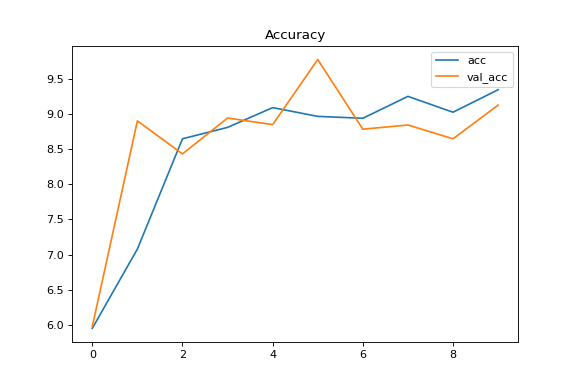

<IPython.core.display.Javascript object>


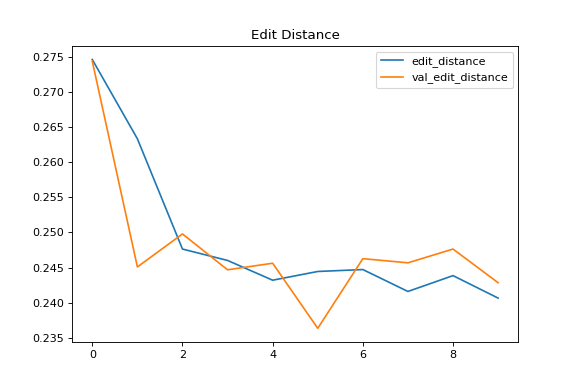

In [85]:
%reload_ext autoreload




history, test_out, start_time, end_time = tweetynet.train_pipeline(train_dataset, val_dataset, test_dataset, 
                                                                   lr=.01, batch_size=128,epochs=10, save_me=True,
                                                                   fine_tuning=False, finetune_path=None)

In [86]:
len(train_dataset)

2214

In [87]:
end_time - start_time

datetime.timedelta(seconds=2875, microseconds=773688)

In [88]:
test_out


uid  zero_pred  one_pred  \
0      XC148386 - Scaly-breasted Woodpecker - Celeus ...   0.637706 -0.550884   
1      XC148386 - Scaly-breasted Woodpecker - Celeus ...   0.592387 -0.576758   
2      XC148386 - Scaly-breasted Woodpecker - Celeus ...   0.584420 -0.580530   
3      XC148386 - Scaly-breasted Woodpecker - Celeus ...   0.583281 -0.581042   
4      XC148386 - Scaly-breasted Woodpecker - Celeus ...   0.583127 -0.581111   
...                                                  ...        ...       ...   
14971  XC238981 - White-throated Toucan - Ramphastos ...  -0.267228 -0.112127   
14972  XC238981 - White-throated Toucan - Ramphastos ...  -0.269046 -0.112020   
14973  XC238981 - White-throated Toucan - Ramphastos ...  -0.264767 -0.112089   
14974  XC238981 - White-throated Toucan - Ramphastos ...  -0.278892 -0.110387   
14975  XC238981 - White-throated Toucan - Ramphastos ...  -0.326012 -0.101691   

       pred  label  
0        10      0  
1        10      0  
2        10      0  
3        10      0  
4        10      0  
...     ...    ...  
14971     3      3  
14972     3      3  
14973     3      3  
14974     3      3  
14975     3      3  

[88704 rows x 5 columns]

In [89]:
chunked_renamed_df.to_csv("formated_tweetynet_ground_truth.csv")

# Visualization

In [90]:
#should categorize this data

In [91]:
a, sr = librosa.load(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))
sr

NameError: name 'folder_name' is not defined

In [ ]:
#-100,-2
idx_here = -100
x = X[idx_here]
y = Y[idx_here]
uid = uids[idx_here]
folder_name = "ff1010bird_wav" if "-" not in uid else "warblrb10k_public_wav"
sr = 44100
x.shape

In [ ]:
show_mel_spectrogram(x.transpose(), uid)
y, uid

In [ ]:
ipd.Audio(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(a, sr=sr)

In [97]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [118]:
predictions = pd.DataFrame()
tweetynet.model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels, uids = data
        inputs = inputs.reshape(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2])
        inputs, labels = inputs.to(tweetynet.device), labels.to(tweetynet.device)

        output = tweetynet.model(inputs, inputs.shape[0], labels.shape[0])
        temp_uids = []
        if tweetynet.binary:
            labels = torch.from_numpy((np.array([[x] * output.shape[-1] for x in labels])))
            temp_uids = np.array([[x] * output.shape[-1] for x in uids])
        else:
            for u in uids:
                for j in range(output.shape[-1]):
                     temp_uids.append(str(j) + "_" + u)
            temp_uids = np.array(temp_uids)
        zero_pred = output[:, 0, :]
        one_pred = output[:, 1, :]
        pred = torch.argmax(output, dim=1)
        
        #labels_dir = {}
        #pred_dir
        #scores_dir
        
        
        d = {} #"uid": temp_uids.flatten(), "pred": pred.flatten(), "label": labels.flatten()
        for i in range(len(species)):
            d[species[i]] = output[:,i, :]
        new_preds = pd.DataFrame(d, index=temp_uids.flatten())
        predictions = predictions.append(new_preds)
print('Finished Testing')
predictions

ValueError: Shape of passed values is (32, 11), indices imply (4608, 11)

In [123]:
output[:, 0, :].shape

torch.Size([32, 144])

In [147]:
test = output[:, 0, :].numpy()



d = {}
label_d = {}
scores = []

label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))

for species_index in range(output.shape[1]):
    print(species_index)
    test = output[:, species_index, :].numpy()
    print(test.shape)
    count = 0
    scores = []
    
    d["uid"] =  temp_uids.flatten()
    print(d["uid"].shape[0])
    
    for file in test:
        for slice_ in file:
            scores.append(slice_)
            count += 1
    d[species[species_index]] = scores
    print(species[species_index], count, len( d[species[species_index]]))
    
    


for key in d:
    pred = torch.argmax(d[key], dim=1)

new_preds = pd.DataFrame(d)
new_preds

0
(32, 144)
4608
Celeus grammicus 4608 4608
1
(32, 144)
4608
Microcerculus marginatus 4608 4608
2
(32, 144)
4608
Myioborus miniatus 4608 4608
3
(32, 144)
4608
Ramphastos tucanus 4608 4608
4
(32, 144)
4608
Thraupis episcopus 4608 4608
5
(32, 144)
4608
Tolmomyias sulphurescens 4608 4608
6
(32, 144)
4608
Trogon viridis 4608 4608
7
(32, 144)
4608
Turdus leucomelas 4608 4608
8
(32, 144)
4608
Xiphorhynchus guttatus 4608 4608
9
(32, 144)
4608
Zonotrichia capensis 4608 4608
10
(32, 144)
4608
no bird 4608 4608
4608
4608
4608
4608
4608
4608
4608
4608
4608
4608
4608
4608


uid  Celeus grammicus  \
0     XC187548 - Green-backed Trogon - Trogon viridi...          0.456844   
1     XC187548 - Green-backed Trogon - Trogon viridi...          0.411354   
2     XC187548 - Green-backed Trogon - Trogon viridi...          0.403591   
3     XC187548 - Green-backed Trogon - Trogon viridi...          0.402480   
4     XC187548 - Green-backed Trogon - Trogon viridi...          0.402329   
...                                                 ...               ...   
4603  XC504735 - Scaly-breasted Woodpecker - Celeus ...          0.185963   
4604  XC504735 - Scaly-breasted Woodpecker - Celeus ...          0.205390   
4605  XC504735 - Scaly-breasted Woodpecker - Celeus ...          0.287108   
4606  XC504735 - Scaly-breasted Woodpecker - Celeus ...          0.032706   
4607  XC504735 - Scaly-breasted Woodpecker - Celeus ...         -0.212531   

      Microcerculus marginatus  Myioborus miniatus  Ramphastos tucanus  \
0                    -0.485934           -0.021283           -0.389262   
1                    -0.511722            0.002170           -0.222473   
2                    -0.515520            0.005631           -0.195419   
3                    -0.516035            0.006100           -0.191613   
4                    -0.516105            0.006163           -0.191096   
...                        ...                 ...                 ...   
4603                 -0.423526            0.170311            0.246541   
4604                 -0.430008            0.182527            0.183355   
4605                 -0.450708            0.248938            0.160970   
4606                 -0.249112            0.193697            0.579599   
4607                 -0.139465            0.249673            0.887230   

      Thraupis episcopus  Tolmomyias sulphurescens  Trogon viridis  \
0               0.304925                 -0.367509       -1.095675   
1               0.228716                 -0.334039       -1.104628   
2               0.216293                 -0.328118       -1.106387   
3               0.214543                 -0.327261       -1.106650   
4               0.214305                 -0.327144       -1.106686   
...                  ...                       ...             ...   
4603            0.193875                 -0.014170       -0.759940   
4604            0.240181                 -0.014616       -0.810636   
4605            0.460445                 -0.026094       -0.806901   
4606            0.062590                  0.124989       -0.671179   
4607           -0.240360                  0.197371       -0.483806   

      Turdus leucomelas  Xiphorhynchus guttatus  Zonotrichia capensis  \
0             -0.593625               -0.560196             -1.323781   
1             -0.492067               -0.593698             -1.309145   
2             -0.476220               -0.598842             -1.306398   
3             -0.474022               -0.599551             -1.305992   
4             -0.473724               -0.599647             -1.305937   
...                 ...                     ...                   ...   
4603          -0.039854               -0.620469             -0.783738   
4604          -0.072811               -0.610505             -0.807757   
4605          -0.050187               -0.434586             -0.864655   
4606           0.162192               -0.427119             -0.570930   
4607           0.401049               -0.306615             -0.312411   

       no bird  
0     0.726774  
1     0.668247  
2     0.659540  
3     0.658354  
4     0.658193  
...        ...  
4603  0.205681  
4604  0.243167  
4605  0.219393  
4606 -0.015250  
4607 -0.245507  

[4608 rows x 12 columns]

In [121]:
temp_uids.flatten().shape

(4608,)

In [122]:
32 * 144


4608

In [114]:
species.index(x)

['Celeus grammicus',
 'Microcerculus marginatus',
 'Myioborus miniatus',
 'Ramphastos tucanus',
 'Thraupis episcopus',
 'Tolmomyias sulphurescens',
 'Trogon viridis',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Zonotrichia capensis',
 'no bird']